In [63]:
import numpy as np
import pandas as pd
import requests
import json
from random import sample
import gc
import math
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import pickle
import seaborn as sns
wd=r'C:/Users/Wilde/Documents/Prueba MercadoLibre/'

In [2]:
# Funcion de  revision de las Variables Continuas

def processContinuous(conFeat, data):
	conHead = ['Count', 'Miss %', 'Card.', 'Min', '1st Qrt.', 'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']
	
	conOutDF = pd.DataFrame(index=conFeat, columns=conHead)
	conOutDF.index.name = 'FEATURENAME'
	columns = data[conFeat]

	#COUNT
	count = columns.count()
	conOutDF[conHead[0]] = count
	
	#MISS % - no continuous features have missing data
	conOutDF[conHead[1]] = columns.isna().sum()
	
	#CARDINALITY
	conOutDF[conHead[2]] = columns.nunique()
	
	#MINIMUM
	conOutDF[conHead[3]] = columns.min()
	
	#1ST QUARTILE
	conOutDF[conHead[4]] = columns.quantile(0.25)
	
	#MEAN
	conOutDF[conHead[5]] = round(columns.mean(), 2)
	
	#MEDIAN
	conOutDF[conHead[6]] = columns.median()
	
	#3rd QUARTILE
	conOutDF[conHead[7]] = columns.quantile(0.75)
	
	#MAX
	conOutDF[conHead[8]] = columns.max()
	
	#STANDARD DEVIATION
	conOutDF[conHead[9]] = round(columns.std(),2)
	
	return conOutDF

In [3]:
# CONSULTA DE CATEGORIAS DE MERCADOLIBRE ARGENTINA
url = "https://api.mercadolibre.com/sites/MLA/categories/all"
response = json.loads(requests.get(url).text)
data=pd.DataFrame.from_dict(response, orient="index")
gc.enable()

In [4]:
# 30 CATEGORIAS CON MAS ITEMS PUBLICADOS 
categorias_mf = data.sort_values('total_items_in_this_category', ascending=False).head(24).iloc[:,0].unique()
categorias_mf=np.append(categorias_mf,['MLA1051','MLA1002'])
#categorias_mf=np.array(['MLA3025']).astype('object')
#categorias_mf=np.array(['MLA412445']).astype('object')
#categorias_mf=np.array(['MLA5725']).astype('object')
#categorias_mf=np.array(['MLA1747']).astype('object')
#categorias_mf=np.array(['MLA1227']).astype('object')

In [5]:
# LISTA DE ITEMS CON LAS CATEGORIAS MAS RELEVANTES
CAT_list = []
seller_list=pd.DataFrame()
offset= np.char.mod('%d',np.arange(0,1000,50)).astype('object')
a = "https://api.mercadolibre.com/sites/MLA/search?category=" + categorias_mf
# LISTA CON LAS CONSULTAS A TRAVÉS DEL OFFSET
val_list=[]
for offset in offset:
    val_list.append(a + "&offset=" + offset)
val_list_2=np.concatenate(val_list,axis=0)

In [6]:
# Para cada categoría,  queremos acceder a su información por la API
for i in range(len(val_list_2)):
    JSONContent = requests.get(val_list_2[i]).json()
    for j in range(len(JSONContent['results'])):
      #   CAT_list.append([JSONContent['results'][x]['seller']['id']])
         CAT_list.append([ JSONContent['results'][j]['id']
                          ,JSONContent['results'][j]['title']
                          ,JSONContent['results'][j]['seller']['id']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['total']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['canceled']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['ratings']['negative']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['ratings']['positive']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['ratings']['neutral']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['completed']
                          #,JSONContent['results'][j]['seller']['seller_reputation']['metrics']['sales']['completed']
                          ,JSONContent['results'][j]['price']
                          ,JSONContent['results'][j]['original_price']
                          ,JSONContent['results'][j]['currency_id']
                          ,JSONContent['results'][j]['available_quantity']
                          ,JSONContent['results'][j]['sold_quantity']
                          ,JSONContent['results'][j]['buying_mode']
                          ,JSONContent['results'][j]['listing_type_id']
                          ,JSONContent['results'][j]['condition']
                          ,JSONContent['results'][j]['accepts_mercadopago']
                          #,JSONContent['results'][x]['installments']['quantity']
                          #,JSONContent['results'][x]['installments']['amount']
                          #,JSONContent['results'][x]['installments']['rate']
                          ,JSONContent['results'][j]['shipping']['free_shipping']
                          ,JSONContent['results'][j]['shipping']['store_pick_up']
                          ,JSONContent['results'][j]['address']['state_name']
                          ,'MLA' + re.search('=MLA(.+?)&offset', val_list_2[i]).group(1)])
         seller_list=seller_list.append([JSONContent['results'][j]['seller']],sort=False)

In [8]:
# CREACION DE BASE DE TRABAJO
dataset = pd.DataFrame(CAT_list)
seller_reputation=pd.DataFrame(seller_list['seller_reputation'].apply(pd.Series)['transactions'].apply(pd.Series))
ratings=seller_reputation['ratings'].apply(pd.Series)[['negative','positive','neutral']]
transactions=seller_reputation[['canceled','completed','total']]
dataset.reset_index(drop=True, inplace=True)
transactions.reset_index(drop=True, inplace=True)
ratings.reset_index(drop=True, inplace=True)
dataset=pd.concat([dataset,transactions,ratings],axis=1, join='inner')
dataset.columns = ['id','title','seller_id','price','original_price','currency_id','available_quantity','sold_quantity',
                    'buying_mode','listing_type_id','condition','accepts_mercadopago','free_shipping','store_pick_up',
                      'state_name','category','canceled','completed','total','negative','positive','neutral']
Category_names=data.sort_values('total_items_in_this_category', ascending=False)[['name']].reset_index()
Category_names.columns=['category','name']
dataset=dataset.merge(Category_names, how='left',left_on=['category'],right_on=['category'])

In [67]:
# DESCARGA DE BASE DE DATOS EN COMPUTADOR LOCAL (la base de datos se descarga para evitar tener que ejecutar nuevamente la informacion)
#dataset.to_csv(wd + "muestra.csv',index=False)
dataset=pd.read_csv(wd + "muestra.csv")

In [68]:
# ANALISIS DE INFORMACION
# Construccion de la variable valor descuento.
dataset['Descuento']= np.where(dataset['original_price'].isna(),0,(dataset.original_price-dataset.price)/dataset.original_price).astype('float')
# Construccion de la variable Flag_Descuento.
dataset['Flag_Descuento']= np.where(dataset['original_price'].isna(),0,1)
# Construccion de la variable ingresos.
dataset['Ingresos']= dataset['price']*dataset['sold_quantity']
# Construccion de la available_quantity en ARS
dataset['available_quantity en ARS']= dataset['price']*dataset['available_quantity']
# Construccion de la variable Ventas Positivas.
dataset['Ventas Positivas']= dataset['total']*dataset['positive']
# Construccion de la variable Ventas Negativas.
dataset['Ventas Negativas']= dataset['total']*dataset['negative']
# Construccion de la variable Ventas Neutrales.
dataset['Ventas Neutrales']= dataset['total']*dataset['neutral']
#Vector de Ciudades
ciudades_mf = dataset['state_name'].unique()
#Vector de Currency
Currency_mf = dataset['currency_id'].unique()
#Vector de Mode
Mode_mf = dataset['buying_mode'].unique()
#Vector de Listing
Listing_mf = dataset['listing_type_id'].unique()
#Vector de condition
condition_mf = dataset['condition'].unique()


Top 10 Precio Promedio por Categoria 
 +-----------------------------+-----------------+
| name                        |           price |
|-----------------------------+-----------------|
| Inmuebles                   |     1.64665e+06 |
| TVs                         | 54874.7         |
| Computación                 | 39049.7         |
| Celulares y Teléfonos       | 16194           |
| Amortiguadores              | 10054.7         |
| Suspensión y Dirección      |  6921.68        |
| Electrónica, Audio y Video  |  6845.46        |
| Motor                       |  6731           |
| Frenos                      |  4801.08        |
| Herramientas y Construcción |  4314.1         |
+-----------------------------+-----------------+
Top 10 Precio Máximo por Categoria 
 +----------------------------+-----------------+
| name                       |           price |
|----------------------------+-----------------|
| Inmuebles                  |      4.8024e+07 |
| TVs                       

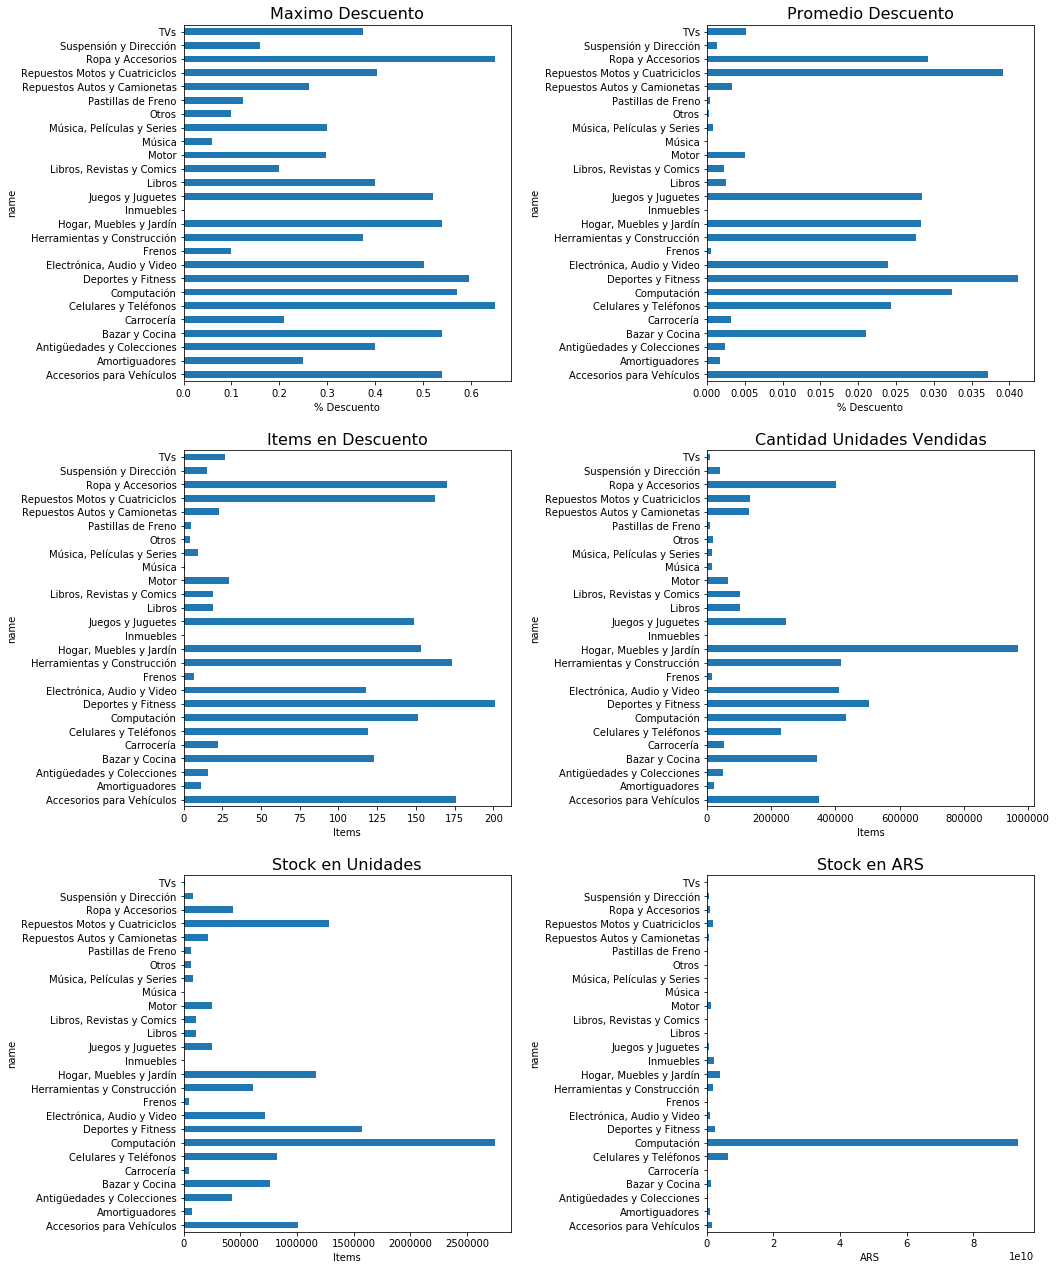

In [11]:
# ANALISIS POR CATEGORÍA
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(figsize=(15, 18) , nrows = 3, ncols = 2)
ax1.set_xlabel("% Descuento")
ax2.set_xlabel("% Descuento")
ax3.set_xlabel("Items")
ax4.set_xlabel("Items")
ax5.set_xlabel("Items")
ax6.set_xlabel("ARS")
ax1.set_title('Maximo Descuento', fontsize=16)
ax2.set_title('Promedio Descuento', fontsize=16)
ax3.set_title('Items en Descuento', fontsize=16)
ax4.set_title('Cantidad Unidades Vendidas', fontsize=16)
ax5.set_title('Stock en Unidades', fontsize=16)
ax6.set_title('Stock en ARS', fontsize=16)

fig.tight_layout()
dataset.groupby(['name'])['Descuento'].max().plot.barh(ax=ax1)
dataset.groupby(['name'])['Descuento'].mean().plot.barh(ax=ax2)
dataset.groupby(['name'])['Flag_Descuento'].sum().plot.barh(ax=ax3)
dataset.groupby(['name'])['sold_quantity'].sum().plot.barh(ax=ax4)
dataset.groupby(['name'])['available_quantity'].sum().plot.barh(ax=ax5)
dataset.groupby(['name'])['available_quantity en ARS'].sum().plot.barh(ax=ax6)
fig.tight_layout(pad=2.0)

print("Top 10 Precio Promedio por Categoria \n", tabulate(dataset.groupby(['name'])['price'].mean().reset_index('name').sort_values('price', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Precio Máximo por Categoria \n", tabulate(dataset.groupby(['name'])['price'].max().reset_index('name').sort_values('price', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Precio Promedio por Categoria \n", tabulate(dataset.groupby(['name'])['price'].mean().reset_index('name').sort_values('price', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Categorias más Vendidas \n", tabulate(dataset.groupby(['name'])['sold_quantity'].sum().reset_index('name').sort_values('sold_quantity', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Categorias más Ingresos \n", tabulate(dataset.groupby(['name'])['Ingresos'].sum().reset_index('name').sort_values('Ingresos', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))


Top 10 Sellers con más ventas Positivas 
 +-------------+--------------------+
|   seller_id |   Ventas Positivas |
|-------------+--------------------|
| 8.95751e+07 |             628555 |
| 1.74557e+08 |             613538 |
| 1.91048e+08 |             517057 |
| 1.42126e+08 |             493430 |
| 8.34175e+07 |             399368 |
| 1.66535e+08 |             396933 |
| 8.29162e+07 |             388409 |
| 1.15764e+08 |             354852 |
| 1.98763e+07 |             352540 |
| 9.87701e+06 |             352495 |
+-------------+--------------------+
Top 10 Sellers con más ventas negativas 
 +------------------+--------------------+
|        seller_id |   Ventas Negativas |
|------------------+--------------------|
|      1.77434e+08 |           27653.8  |
|      8.95751e+07 |           20060.3  |
|      1.74557e+08 |           19374.9  |
|      8.34175e+07 |           12745.8  |
|      1.98763e+07 |           11251.3  |
| 109089           |           10804.5  |
|      4.4778e+07  |

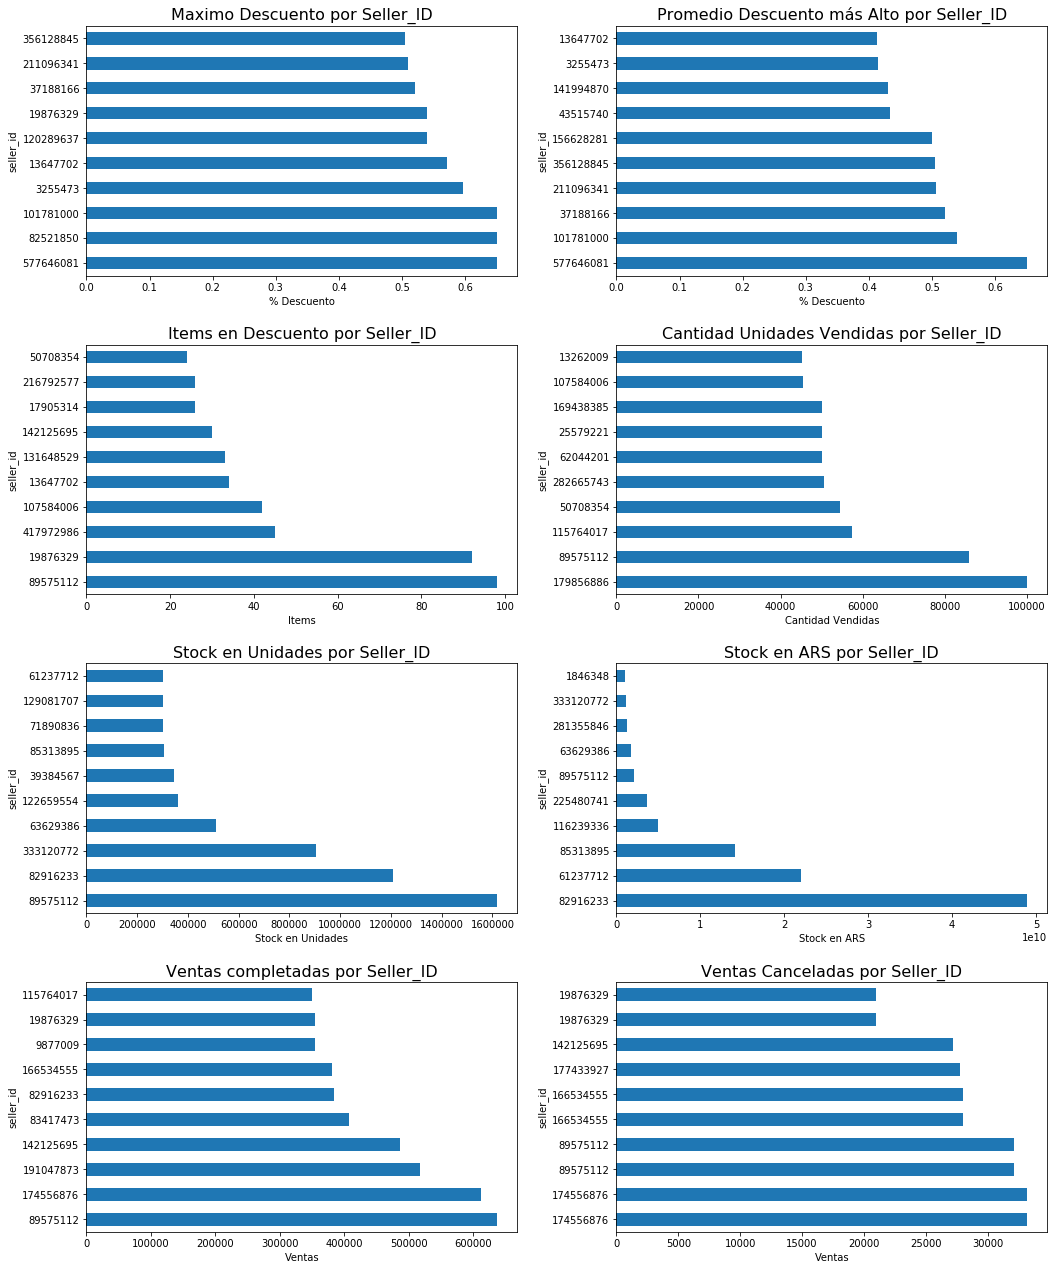

In [12]:
# ANALISIS POR SELLER
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6),  (ax7,ax8)) = plt.subplots(figsize=(15, 18) , nrows = 4, ncols = 2)
ax1.set_xlabel("% Descuento")
ax2.set_xlabel("% Descuento")
ax3.set_xlabel("Items")
ax4.set_xlabel("Cantidad Vendidas")
ax5.set_xlabel("Stock en Unidades")
ax6.set_xlabel("Stock en ARS")
ax7.set_xlabel("Ventas")
ax8.set_xlabel("Ventas")

ax1.set_title('Maximo Descuento por Seller_ID', fontsize=16)
ax2.set_title('Promedio Descuento más Alto por Seller_ID', fontsize=16)
ax3.set_title('Items en Descuento por Seller_ID', fontsize=16)
ax4.set_title('Cantidad Unidades Vendidas por Seller_ID', fontsize=16)
ax5.set_title('Stock en Unidades por Seller_ID', fontsize=16)
ax6.set_title('Stock en ARS por Seller_ID', fontsize=16)
ax7.set_title('Ventas completadas por Seller_ID', fontsize=16)
ax8.set_title('Ventas Canceladas por Seller_ID', fontsize=16)

fig.tight_layout()
dataset.groupby(['seller_id'])['Descuento'].max().reset_index('seller_id').set_index('seller_id').sort_values('Descuento', ascending=False).head(10).plot.barh(ax=ax1,legend=False)
dataset.groupby(['seller_id'])['Descuento'].mean().reset_index('seller_id').set_index('seller_id').sort_values('Descuento', ascending=False).head(10).plot.barh(ax=ax2,legend=False)
dataset.groupby(['seller_id'])['Flag_Descuento'].sum().reset_index('seller_id').set_index('seller_id').sort_values('Flag_Descuento', ascending=False).head(10).plot.barh(ax=ax3,legend=False)
dataset.groupby(['seller_id'])['sold_quantity'].sum().reset_index('seller_id').set_index('seller_id').sort_values('sold_quantity', ascending=False).head(10).plot.barh(ax=ax4,legend=False)
dataset.groupby(['seller_id'])['available_quantity'].sum().reset_index('seller_id').set_index('seller_id').sort_values('available_quantity', ascending=False).head(10).plot.barh(ax=ax5,legend=False)
dataset.groupby(['seller_id'])['available_quantity en ARS'].sum().reset_index('seller_id').set_index('seller_id').sort_values('available_quantity en ARS', ascending=False).head(10).plot.barh(ax=ax6,legend=False)
dataset.groupby(['seller_id'])['completed'].max().reset_index('seller_id').set_index('seller_id').sort_values('completed', ascending=False).head(10).plot.barh(ax=ax7,legend=False)
dataset[['seller_id','canceled']].drop_duplicates().sort_values('canceled', ascending=False).head(10).set_index('seller_id').plot.barh(ax=ax8,legend=False)
fig.tight_layout(pad=2.0)

print("Top 10 Sellers con más ventas Positivas \n", tabulate(dataset.groupby(['seller_id'])['Ventas Positivas'].max().reset_index('seller_id').sort_values('Ventas Positivas', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Sellers con más ventas negativas \n", tabulate(dataset.groupby(['seller_id'])['Ventas Negativas'].max().reset_index('seller_id').sort_values('Ventas Negativas', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Seller con más ventas Neutrales \n", tabulate(dataset.groupby(['seller_id'])['Ventas Neutrales'].max().reset_index('seller_id').sort_values('Ventas Neutrales', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))
print("Top 10 Seller con más Ingresos \n", tabulate(dataset.groupby(['seller_id'])['Ingresos'].sum().reset_index('seller_id').sort_values('Ingresos', ascending=False).head(10), headers='keys', tablefmt='psql',showindex="never"))

In [69]:
# PREPARACION DE DATOS PARA EL MODELO (ELIMINACION DE NULLS Y VARIABLES SIN RELEVANCIA)

#Cambio de la variable original_price              
dataset['original_price_2']= np.where(dataset['original_price'].isna(),dataset.price,dataset['original_price']).astype(int)

#Eliminacion de Columnas no utiles 
dataset.drop('title', axis=1, inplace=True)
dataset.drop('id', axis=1, inplace=True)
dataset.drop('seller_id', axis=1, inplace=True)
dataset.drop('original_price', axis=1, inplace=True)
dataset.drop('name', axis=1, inplace=True)
dataset.drop('Ingresos', axis=1, inplace=True)


#Eliminacion de Filas que no contienen información suficiente para ser tenida en cuenta
dataset=dataset[dataset['neutral'].notna()]

#Eliminacion de Outliers de la variable respuesta
Q1 = dataset['sold_quantity'].quantile(0.25)
Q3 = dataset['sold_quantity'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
dataset=dataset[~((dataset['sold_quantity'] < (Q1 - 1.5 * IQR)) | (dataset['sold_quantity']  > (Q3 + 1.5 * IQR)))]

dataset.info()
dataset.shape



245.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25027 entries, 1 to 25717
Data columns (total 25 columns):
price                        25027 non-null float64
currency_id                  25027 non-null object
available_quantity           25027 non-null int64
sold_quantity                25027 non-null int64
buying_mode                  25027 non-null object
listing_type_id              25027 non-null object
condition                    25027 non-null object
accepts_mercadopago          25027 non-null bool
free_shipping                25027 non-null bool
store_pick_up                25027 non-null bool
state_name                   25027 non-null object
category                     25027 non-null object
canceled                     25027 non-null float64
completed                    25027 non-null float64
total                        25027 non-null float64
negative                     25027 non-null float64
positive                     25027 non-null float64
neutral             

(25027, 25)

In [70]:
# INFORMACIÓN ESTADISTICA DE LAS VARIABLES NUMERICAS
condf = dataset.select_dtypes([np.number]).columns.tolist()
statcondf=processContinuous(condf,dataset)
print(statcondf)

                           Count  Miss %  Card.   Min  1st Qrt.        Mean  \
FEATURENAME                                                                   
price                      25027       0   7925  22.0   950.000    73063.36   
available_quantity         25027       0      9   1.0     1.000      478.58   
sold_quantity              25027       0     13   0.0     5.000      141.23   
canceled                   25027       0   1546   0.0   135.000     1999.14   
completed                  25027       0   3948   0.0  3042.000    41640.12   
total                      25027       0   3991   0.0  3175.000    43639.26   
negative                   25027       0     27   0.0     0.000        0.01   
positive                   25027       0     32   0.0     0.970        0.94   
neutral                    25027       0     26   0.0     0.000        0.01   
Descuento                  25027       0   1206   0.0     0.000        0.01   
Flag_Descuento             25027       0      2   0.

In [71]:
# PREPARACION DE DATOS PARA EL MODELO (ONE HOT ENCODER)
onehot_columns = ['currency_id', 'buying_mode', 'listing_type_id', 'condition', 'state_name', 'category']
onehot_dataset = dataset[onehot_columns]
onehot_dataset = pd.get_dummies(onehot_dataset, columns = onehot_columns)
score_onehot_drop = dataset.drop(onehot_columns, axis = 1)
score_onehot = pd.concat([score_onehot_drop, onehot_dataset], axis = 1)

In [106]:
# Dividir la muestra entre Train and Test
train_all, test_all = train_test_split(score_onehot, test_size=0.30, random_state=42)

#Parametros de la regresion
#params = {"colsample_bytree": uniform(0.7, 0.3),
#          "gamma": uniform(0, 0.5),
#          "learning_rate": uniform(0.003, 0.3), # default 0.1 
#          "max_depth": randint(2, 6), # default 3
#         "n_estimators": randint(100, 350), # default 100
#          "subsample": uniform(0.6, 0.4)}
#
##Definición del Regresor
#xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
#time_split = TimeSeriesSplit(n_splits = 7)
#xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=4, cv=time_split, verbose=1, n_jobs=2, return_train_score=True)
#xgb_search.fit(train_all.drop('sold_quantity', axis=1), train_all['sold_quantity'])

In [91]:
# ENTRENAMIENTO DE LOS DATOS
#best_model=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#             colsample_bynode=1, colsample_bytree=0.7550213529560301,
#             gamma=0.15212112147976886, gpu_id=-1, importance_type='gain',
#             interaction_constraints='', learning_rate=0.16042692948967135,
#             max_delta_step=0, max_depth=5, min_child_weight=1,
#             monotone_constraints='()', n_estimators=188, n_jobs=0,
#             num_parallel_tree=1, objective='reg:squarederror', random_state=42,
#             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#             subsample=0.7164916560792167, tree_method='exact',
#             validate_parameters=1, verbosity=None)

#best_model.fit(train_all.drop('sold_quantity', axis=1), train_all['sold_quantity'])

#GUARDAR Y CARGAR EL MODELO
#pickle.dump(best_model, open(wd + "xq_sold_qua.dat", "wb"))
best_model=pickle.load(open(wd + "xq_sold_qua.dat", "rb"))


In [92]:
#Prediccion de la información y calculo del RMSE
y_pred = best_model.predict(test_all.drop('sold_quantity', axis=1))
R_cuad=r2_score(test_all['sold_quantity'], y_pred, multioutput='variance_weighted')
rms = sqrt(mean_squared_error(test_all['sold_quantity'], y_pred))
print ('RMSE:', rms)
print('Valor R2:', R_cuad)

RMSE: 100.14192545505628
Valor R2: 0.6767246698180758


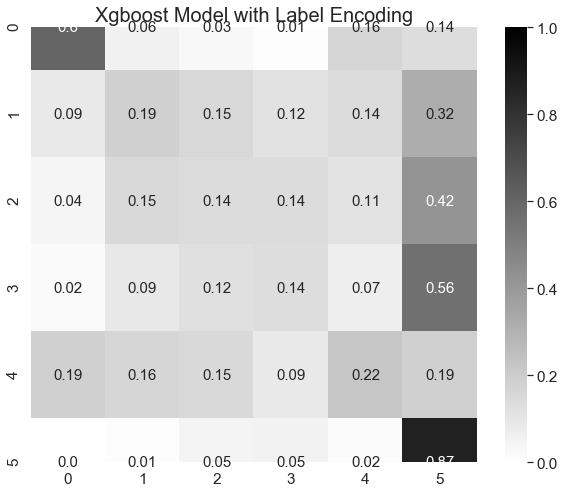

In [93]:
# Creación de la Matrix de confusion para cada rango de la variable respuesta

def flag_feature(x):
    if x >= 0 and x < 51:
        return '0-51'
    elif x >= 51 and x < 101:
        return '51-101'
    elif x >= 101 and x < 151:
        return '101-151'
    elif x >= 151 and x < 201:
        return '151-201'
    elif x >= 201 and x < 251:
        return '201-251'
#    elif x >= 300 and x < 350:
#        return '300-350'
#    elif x >= 350 and x < 400:
#        return '350-400'
#    elif x >= 400 and x < 450:
#        return '400-450'    
    else:
        return '>251'
    
obs_pre = pd.DataFrame(zip(test_all['sold_quantity'], y_pred.clip(0,50000)))
cols = ['Real', 'Predict']
obs_pre.columns = cols
obs_pre['Real_flag'] = obs_pre['Real'].apply(flag_feature)
obs_pre['Predict_flag'] = obs_pre['Predict'].apply(flag_feature)
conf = confusion_matrix(obs_pre['Real_flag'], obs_pre['Predict_flag'])
conf_norm = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
conf_norm_round = np.round(conf_norm, decimals = 2)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
sns.set(font_scale=1.4, color_codes = 'w')
ax = sns.heatmap(conf_norm, cmap="binary", annot = conf_norm_round, annot_kws={"size": 15}, fmt = '', vmin=0, vmax=1)
#ax.set(xlabel=class_dict)
ax.set_title('Xgboost Model with Label Encoding', fontsize=20)
plt.show()

In [103]:
# Pipeline de calificacion de consulta

def prediccion_query(query,offset):
    CAT_list=[]
    seller_list=pd.DataFrame()
    JSONContent = requests.get("https://api.mercadolibre.com/sites/MLA/search?q=" + query.replace(" ", "%20") + str(offset)).json()
    for j in range(len(JSONContent['results'])):
        CAT_list.append([ JSONContent['results'][j]['id']
                              ,JSONContent['results'][j]['title']
                              ,JSONContent['results'][j]['seller']['id']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['total']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['canceled']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['ratings']['negative']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['ratings']['positive']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['ratings']['neutral']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['transactions']['completed']
                              #,JSONContent['results'][j]['seller']['seller_reputation']['metrics']['sales']['completed']
                              ,JSONContent['results'][j]['price']
                              ,JSONContent['results'][j]['original_price']
                              ,JSONContent['results'][j]['currency_id']
                              ,JSONContent['results'][j]['available_quantity']
                              ,JSONContent['results'][j]['sold_quantity']
                              ,JSONContent['results'][j]['buying_mode']
                              ,JSONContent['results'][j]['listing_type_id']
                              ,JSONContent['results'][j]['condition']
                              ,JSONContent['results'][j]['accepts_mercadopago']
                              #,JSONContent['results'][x]['installments']['quantity']
                              #,JSONContent['results'][x]['installments']['amount']
                              #,JSONContent['results'][x]['installments']['rate']
                              ,JSONContent['results'][j]['shipping']['free_shipping']
                              ,JSONContent['results'][j]['shipping']['store_pick_up']
                              ,JSONContent['results'][j]['address']['state_name']
                              ,JSONContent['results'][j]['category_id']])
        seller_list=seller_list.append([JSONContent['results'][j]['seller']],sort='False')
            
    dataset = pd.DataFrame(CAT_list)
    seller_reputation=pd.DataFrame(seller_list['seller_reputation'].apply(pd.Series)['transactions'].apply(pd.Series))
    ratings=seller_reputation['ratings'].apply(pd.Series)[['negative','positive','neutral']]
    transactions=seller_reputation[['canceled','completed','total']]
    dataset.reset_index(drop=True, inplace=True)
    transactions.reset_index(drop=True, inplace=True)
    ratings.reset_index(drop=True, inplace=True)
    dataset=pd.concat([dataset,transactions,ratings],axis=1, join='inner')
    dataset.columns = ['id','title','seller_id','price','original_price','currency_id','available_quantity','sold_quantity',
                        'buying_mode','listing_type_id','condition','accepts_mercadopago','free_shipping','store_pick_up',
                          'state_name','category','canceled','completed','total','negative','positive','neutral']    
        # ANALISIS DE INFORMACION
    # Construccion de la variable valor descuento.
    dataset['Descuento']= np.where(dataset['original_price'].isna(),0,(dataset.original_price-dataset.price)/dataset.original_price).astype('float')
    # Construccion de la variable Flag_Descuento.
    dataset['Flag_Descuento']= np.where(dataset['original_price'].isna(),0,1)
    # Construccion de la variable ingresos.
    dataset['Ingresos']= dataset['price']*dataset['sold_quantity']
    # Construccion de la available_quantity en ARS
    dataset['available_quantity en ARS']= dataset['price']*dataset['available_quantity']
    # Construccion de la variable Ventas Positivas.
    dataset['Ventas Positivas']= dataset['total']*dataset['positive']
    # Construccion de la variable Ventas Negativas.
    dataset['Ventas Negativas']= dataset['total']*dataset['negative']
    # Construccion de la variable Ventas Neutrales.
    dataset['Ventas Neutrales']= dataset['total']*dataset['neutral']
    
    # PREPARACION DE DATOS PARA EL MODELO (ELIMINACION DE NULLS Y VARIABLES SIN RELEVANCIA)

    #Cambio de la variable original_price              
    dataset['original_price_2']= np.where(dataset['original_price'].isna(),dataset.price,dataset['original_price']).astype(int)

    #Eliminacion de Columnas no utiles 
    dataset.drop('title', axis=1, inplace=True)
    dataset.drop('seller_id', axis=1, inplace=True)
    dataset.drop('original_price', axis=1, inplace=True)
    dataset.drop('Ingresos', axis=1, inplace=True)

    #Eliminacion de Filas que no contienen información suficiente para ser tenida en cuenta
    dataset=dataset[dataset['neutral'].notna()]

    # PREPARACION DE DATOS PARA EL MODELO (ONE HOT ENCODER)
    
    onehot_columns = ['currency_id', 'buying_mode', 'listing_type_id', 'condition', 'state_name', 'category']
    onehot_dataset = dataset[onehot_columns]
    onehot_dataset = pd.get_dummies(onehot_dataset, columns = onehot_columns)
    score_onehot_drop = dataset.drop(onehot_columns, axis = 1)
    score_onehot = pd.concat([score_onehot_drop, onehot_dataset], axis = 1)

    #cat_encoder="category_" + categorias_mf
    #ciudad_encoder="state_name_" + ciudades_mf
    #Currency_encoder="currency_id_" + Currency_mf
    #Mode_encoder="buying_mode_" + Mode_mf
    #Listing_encoder="listing_type_id_" + Listing_mf
    #condition_encoder="condition_" + condition_mf

    cat_encoder="category_" + np.array(['MLA3025', 'MLA412445', 'MLA5725', 'MLA1747', 'MLA1227', 'MLA1574','MLA1430', 'MLA3172', 'MLA1168', 'MLA22222', 'MLA1174',
           'MLA407134', 'MLA22291', 'MLA1132', 'MLA373359', 'MLA1276','MLA1648', 'MLA1771', 'MLA1459', 'MLA61177', 'MLA1592', 'MLA1367',
           'MLA45548', 'MLA1000', 'MLA1051', 'MLA1002']).astype('object')

    ciudad_encoder="state_name_" + np.array(['Capital Federal', 'Buenos Aires', 'Chubut', 'Santa Fe', 'Córdoba','Mendoza', 'Santiago del Estero', 'Misiones','Bs.As. G.B.A. Norte', 'Tucumán', 'Entre Ríos', 'Río Negro',
           'Bs.As. G.B.A. Sur', 'Bs.As. G.B.A. Oeste', 'Neuquén', 'La Pampa','Corrientes', 'Buenos Aires Interior', 'Bs.As. Costa Atlántica',
           'Jujuy', 'Formosa', 'San Juan', 'San Luis', 'La Rioja', 'Uruguay','Salta', 'Brasil', 'Chaco', 'Catamarca', 'Santa Cruz']).astype('object')

    Currency_encoder="currency_id_" + np.array(['ARS', 'USD']).astype('object')
    Mode_encoder="buying_mode_" + np.array(['buy_it_now', 'classified']).astype('object')
    Listing_encoder="listing_type_id_" + np.array(['gold_special', 'gold_pro', 'gold_premium', 'gold', 'silver']).astype('object')
    condition_encoder="condition_" + np.array(['new', 'used', 'not_specified']).astype('object')

    for i in range(len(cat_encoder)):
        if cat_encoder[i] not in score_onehot.columns:
            score_onehot[cat_encoder[i]]=0

    for i in range(len(ciudad_encoder)):
        if ciudad_encoder[i] not in score_onehot.columns:
            score_onehot[ciudad_encoder[i]]=0

    for i in range(len(Mode_encoder)):
        if Mode_encoder[i] not in score_onehot.columns:
            score_onehot[Mode_encoder[i]]=0

    for i in range(len(Currency_encoder)):
        if Currency_encoder[i] not in score_onehot.columns:
            score_onehot[Currency_encoder[i]]=0

    for i in range(len(Listing_encoder)):
        if Listing_encoder[i] not in score_onehot.columns:
            score_onehot[Listing_encoder[i]]=0

    for i in range(len(condition_encoder)):
        if condition_encoder[i] not in score_onehot.columns:
            score_onehot[condition_encoder[i]]=0

    columnas=np.array(['price', 'available_quantity', 'accepts_mercadopago',
           'free_shipping', 'store_pick_up', 'canceled', 'completed', 'total',
           'negative', 'positive', 'neutral', 'Descuento', 'Flag_Descuento',
           'available_quantity en ARS', 'Ventas Positivas', 'Ventas Negativas',
           'Ventas Neutrales', 'original_price_2', 'currency_id_ARS',
           'currency_id_USD', 'buying_mode_buy_it_now', 'buying_mode_classified',
           'listing_type_id_gold', 'listing_type_id_gold_premium',
           'listing_type_id_gold_pro', 'listing_type_id_gold_special',
           'listing_type_id_silver', 'condition_new', 'condition_not_specified',
           'condition_used', 'state_name_Brasil',
           'state_name_Bs.As. Costa Atlántica', 'state_name_Bs.As. G.B.A. Norte',
           'state_name_Bs.As. G.B.A. Oeste', 'state_name_Bs.As. G.B.A. Sur',
           'state_name_Buenos Aires', 'state_name_Buenos Aires Interior',
           'state_name_Capital Federal', 'state_name_Catamarca',
           'state_name_Chaco', 'state_name_Chubut', 'state_name_Corrientes',
           'state_name_Córdoba', 'state_name_Entre Ríos', 'state_name_Formosa',
           'state_name_Jujuy', 'state_name_La Pampa', 'state_name_La Rioja',
           'state_name_Mendoza', 'state_name_Misiones', 'state_name_Neuquén',
           'state_name_Río Negro', 'state_name_Salta', 'state_name_San Juan',
           'state_name_San Luis', 'state_name_Santa Cruz', 'state_name_Santa Fe',
           'state_name_Santiago del Estero', 'state_name_Tucumán',
           'state_name_Uruguay', 'category_MLA1000', 'category_MLA1002',
           'category_MLA1051', 'category_MLA1132', 'category_MLA1168',
           'category_MLA1174', 'category_MLA1227', 'category_MLA1276',
           'category_MLA1367', 'category_MLA1430', 'category_MLA1459',
           'category_MLA1574', 'category_MLA1592', 'category_MLA1648',
           'category_MLA1747', 'category_MLA1771', 'category_MLA22222',
           'category_MLA22291', 'category_MLA3025', 'category_MLA3172',
           'category_MLA373359', 'category_MLA407134', 'category_MLA412445',
           'category_MLA45548', 'category_MLA5725', 'category_MLA61177']).astype('object')

    obs_pre = pd.DataFrame(zip(score_onehot['id'],best_model.predict(score_onehot[columnas]).clip(0, 50000),score_onehot['sold_quantity']))
    cols = ['ID', 'Sold_Quantity_Predict', 'Real']
    obs_pre.columns = cols
    return obs_pre

In [105]:
prediccion_query("Televisor 52",500)

,ID,Sold_Quantity_Predict,Real
0,MLA835435026,231.088394,500
1,MLA734087526,265.241791,500
2,MLA609850545,309.068298,500
3,MLA677249832,354.904480,500
4,MLA735421134,315.156769,500
5,MLA630791885,124.399170,5
6,MLA712349710,71.386482,0
7,MLA711532720,238.354431,500
8,MLA689635578,270.461029,500
9,MLA734996102,124.399170,1
